# RL - Learning to Run Power Network Assignment 
## PPO Models

Milisa Sithole - 2446396 \
Oriinga Maudu - 2433303 \
Kudzai Realeboga Saurombe - 2503314 \
Tapiwa Chatikobo - 2442335

## Imports 

In [1]:
import gymnasium as gym

import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
from stable_baselines3.common.callbacks import BaseCallback

import numpy as np
import matplotlib.pyplot as plt
from grid2op.Chronics import MultifolderWithCache
from l2rpn_baselines.PPO_SB3 import train, evaluate, PPO_SB3
from grid2op.gym_compat import BoxGymObsSpace, BoxGymActSpace, DiscreteActSpaceGymnasium
from stable_baselines3.ppo import MlpPolicy
from grid2op.Runner import Runner
import re
import copy

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


## Environment Setup

In [37]:
class Gym2OpEnv(gym.Env):
    def __init__(
            self,
            test = False,
            obs_type="full",
            act_type="full_discrete",
            normalise=False
            
    ):
        super().__init__()
        self._backend = LightSimBackend()

        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE
        self.normalise = normalise

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=test,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        # reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations(obs_type)
        self.setup_actions(act_type)

        self.observation_space = self._gym_env.observation_space
        self.action_space = self._gym_env.action_space
    
    ########## Observations not used at all #########
    '''
    Disctrete observations: 
        'day', 'day_of_week', 'hour_of_day', 'is_alarm_illegal', 'line_status',  
        'minute_of_hour', 'month', , 'was_alarm_used_after_game_over', 'year'
    
    Maintenance or oppenent or storage:
        'duration_next_maintenance', 'time_next_maintenance'
    
    Not for our env:
        'time_since_last_alarm'
    '''
    ##################################################

    def setup_observations(self, obs_type):
        # TODO: Your code to specify & modify the observation space goes here
        # See Grid2Op 'getting started' notebooks for guidance
        #  - Notebooks: https://github.com/rte-france/Grid2Op/tree/master/getting_started

        if obs_type == "full":
            '''
            obs_attr_to_keep = ['gen_p', 'gen_q', 'gen_v', 'load_p', 'load_q', 'load_v', 'a_ex', 
                                'a_or', 'p_ex', 'p_or', 'q_ex', 'q_or', 'v_ex', 'v_or', 'rho', 
                                'topo_vect', 'target_dispatch', 'actual_dispatch', 'gen_p_before_curtail', 
                                'curtailment_limit', 'curtailment_limit_effective', 'time_before_cooldown_line', 
                                'time_before_cooldown_sub', 'timestep_overflow', 'actual_dispatch','attention_budget', 
                                'current_step', 'curtailment', 'curtailment_limit', 'curtailment_limit_effective',
                                'delta_time', 'gen_margin_down', 'gen_margin_up', 'gen_p_before_curtail', 'max_step', 
                                'target_dispatch', 'thermal_limit']
            '''
            obs_attr_to_keep = ['a_ex', 'a_or', 'actual_dispatch','attention_budget', 
                                'current_step', 'curtailment', 'curtailment_limit', 'curtailment_limit_effective', 
                                'delta_time', 'gen_margin_down', 'gen_margin_up', 'gen_p', 'gen_p_before_curtail', 
                                'gen_q', 'gen_theta', 'gen_v', 'load_p', 'load_q', 'load_theta', 'load_v', 'max_step', 
                                'p_ex', 'p_or', 'q_ex', 'q_or', 'rho', 'target_dispatch', 'thermal_limit', 'theta_ex', 
                                'theta_or', 'time_before_cooldown_line', 
                                'time_before_cooldown_sub', 'timestep_overflow', 'topo_vect', 'v_ex', 'v_or']
            self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                            attr_to_keep=obs_attr_to_keep
                                                            )
            
        elif obs_type == "reduced":
            obs_attr_to_keep = ['gen_p', 'gen_q', 'gen_v', 'load_p', 'load_q', 'load_v','a_ex', 
                                'a_or', 'p_ex', 'p_or', 'q_ex', 'q_or', 'v_ex', 'v_or', 'rho', 
                                'topo_vect', 'target_dispatch', 'actual_dispatch', 
                                'gen_p_before_curtail', 'curtailment_limit', 'curtailment_limit_effective' ]
            self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                            attr_to_keep=obs_attr_to_keep
                                                            )
            
        else:
            raise NotImplementedError(f"observation type '{obs_type}' is not currently supported.")
        
        
    def setup_actions(self, act_type):
        # TODO: Your code to specify & modify the action space goes here
        # See Grid2Op 'getting started' notebooks for guidance
        #  - Notebooks: https://github.com/rte-france/Grid2Op/tree/master/getting_started

        if act_type == "full_discrete":
            act_attr_to_keep =  ['curtail', 'redispatch', 'set_bus', 'set_line_status', 'change_bus', 'change_line_status']
            self._gym_env.action_space = DiscreteActSpaceGymnasium(self._g2op_env.action_space,
                                                          attr_to_keep=act_attr_to_keep)
            
        elif act_type == "box":
            act_attr_to_keep = ['curtail', 'redispatch']
            self._gym_env.action_space = BoxGymActSpace(self._g2op_env.action_space,
                                      attr_to_keep=act_attr_to_keep)

        elif act_type == "discrete":
            act_attr_to_keep =  ["set_line_status", "set_bus", 'change_bus', 'change_line_status']
            self._gym_env.action_space = DiscreteActSpaceGymnasium(self._g2op_env.action_space,
                                                          attr_to_keep=act_attr_to_keep)
            
        else:
            raise NotImplementedError(f"action type '{act_type}' is not currently supported.")

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        def normalise_observation(obs):
            obs_min = np.zeros_like(obs)
            obs_max = np.ones_like(obs)
            normalized_obs = (obs - obs_min) / (obs_max - obs_min)
            return np.clip(normalized_obs, 0, 1)

        obs, reward, done, info, _ = self._gym_env.step(action)
        if self.normalise:
            obs = normalise_observation(obs)
        return obs, reward, done, info, _

    def render(self):
        # TODO: Modify for your own required usage
        return self._gym_env.render()


## Reward Tracker

In [12]:
class RewardLogger(BaseCallback):
    def __init__(self, verbose: int = 1):
        super(RewardLogger, self).__init__(verbose)
        self.episode_rewards = []
        self.losses = []

    def _on_step(self) -> bool:
        # Log the reward when an episode ends
        if self.locals["dones"][0]:
            # Retrieve the last episode reward
            episode_reward = self.locals["infos"][0].get("episode", {}).get("r", 0)
            self.episode_rewards.append(episode_reward)
            if self.verbose > 0:
                print(f"Step: {len(self.episode_rewards)}, Episode Reward: {episode_reward}")

        return True

    def get_rewards(self):
        return np.array(self.episode_rewards)

## Main Learning

In [38]:
if __name__ == "__main__":

    obs_type = "full"  
    act_type = "full_discrete"
    normalise = False
    
    env = Gym2OpEnv(obs_type=obs_type, act_type=act_type, normalise= normalise)

    sb3_algo1 = PPO("MlpPolicy", env) #learning_rate=0.0009, ent_coef= 0.003
    reward_and_loss_logger = RewardLogger(verbose=1)
    
    sb3_algo1.learn(total_timesteps=1_000_000,callback=reward_and_loss_logger) 
    sb3_algo1.save("ppo_model")

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treat

Step: 1, Episode Reward: 0.400021
Step: 2, Episode Reward: 0.024289
Step: 3, Episode Reward: 0.055833
Step: 4, Episode Reward: 0.166201
Step: 5, Episode Reward: -0.190577
Step: 6, Episode Reward: -0.303861
Step: 7, Episode Reward: 0.095608
Step: 8, Episode Reward: -0.20764
Step: 9, Episode Reward: -0.5


KeyboardInterrupt: 

## Learning Plot

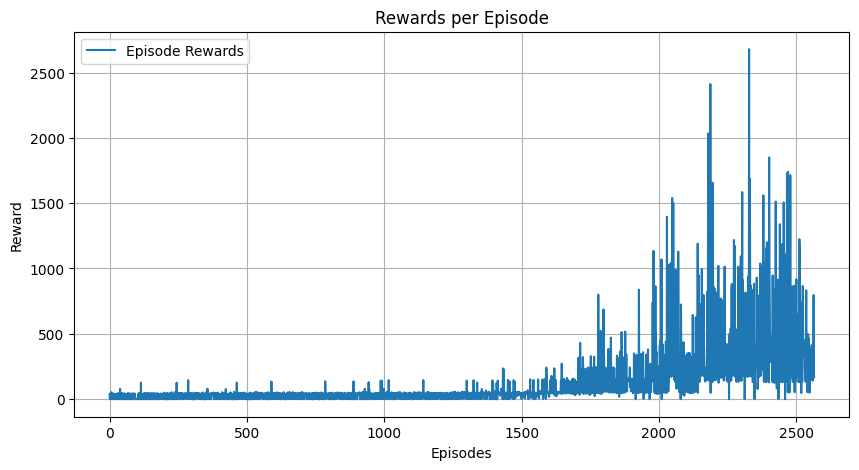

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(reward_and_loss_logger.get_rewards(), label='Episode Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.grid()
plt.show()

## Model Evaluation

In [36]:
# Evaluates model performance over 100 episodes each with max steps of 1000
max_steps = 1000

obs_type = "full"  
act_type = "full_discrete"
normalise = False
    
env = Gym2OpEnv(obs_type=obs_type, act_type=act_type, normalise=normalise)

model = PPO.load("./PPO_saved_models/baseline_model")

rewards = []
for i in range(100):
        eps_reward = 0
        obs, info = env.reset()
        is_done = False
        curr_step = 0
        while not is_done and curr_step < max_steps:
                action = model.predict(obs)
                obs, reward, terminated, truncated, info = env.step(action[0])

                curr_step += 1
                eps_reward += reward
                is_done = terminated or truncated

        rewards.append(eps_reward)
        
print("Max reward:",np.max(rewards))
print("Total reward:",np.sum(rewards))
print("Average reward:",np.mean(rewards))

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treat

Max reward: 355.00559391081333
Total reward: 19045.9647288993
Average reward: 190.459647288993
